In [8]:
!pip install torchtune
!pip install torchao
import torch.nn as nn
import torch
import numpy as np
import random
import os
import torchtune.modules as ttm
import time
import tqdm
from sklearn.metrics import recall_score, precision_score
import json
import matplotlib.pyplot as plt

In [9]:
def seed(seed=1):
    global rank   
    global random_seed 
    random_seed = seed
    #lib seeds
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    rank = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #determinstic vars 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
def create_loaders(rank, batch_size=16):
    # Load the tensors from files
    train_images = torch.load(r'/kaggle/input/imagenet-10/image_net_10/train_images.pt', weights_only=True)
    train_labels = torch.load(r'/kaggle/input/imagenet-10/image_net_10/train_labels.pt', weights_only=True)

    val_images = torch.load(r'/kaggle/input/imagenet-10/image_net_10/val_images.pt', weights_only=True)
    val_labels = torch.load(r'/kaggle/input/imagenet-10/image_net_10/val_labels.pt', weights_only=True)

    test_images = torch.load(r'/kaggle/input/imagenet-10/image_net_10/test_images.pt', weights_only=True)
    test_labels = torch.load(r'/kaggle/input/imagenet-10/image_net_10/test_labels.pt', weights_only=True)

    train_dataset = torch.utils.data.TensorDataset(train_images.float(), train_labels.long())
    val_dataset = torch.utils.data.TensorDataset(val_images.float(), val_labels.long())
    test_dataset = torch.utils.data.TensorDataset(test_images.float(), test_labels.long())



    def collate_gpu(batch):
        return (ele.to(rank) for ele in torch.utils.data.default_collate(batch))
    
    num_workers = 0
    persistent_workers = False
    #dataloaders 
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, shuffle=True, collate_fn=collate_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, collate_fn=collate_gpu)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, collate_fn=collate_gpu)

    return train_loader, val_loader, test_loader

In [11]:
from copy import deepcopy
class EarlyStoppingLoss():
    def __init__(self, patience):
        self._patience = patience
        self.current_patience = 0
        self.min_loss = float('inf')
        self.val_accuracy = None
        self.min_state_dict = None
        self.train_loss = None
        self.train_accuracy = None
        self.epoch = 0
        self.kept_epoch = None

    def stopper(self, current_model, train_loss, val_loss, train_accuracy=None, val_accuracy=None, val_f1=None, val_recall=None, val_precision=None):
        self.epoch += 1
        if val_loss < self.min_loss:
            self.train_loss = train_loss
            self.min_loss = val_loss
            
            self.train_accuracy = train_accuracy
            self.val_accuracy = val_accuracy

            self.val_recall = val_recall
            self.val_precision = val_precision

            self.val_f1 = val_f1 

            self.current_patience = 0
            self.min_state_dict = deepcopy({key: value.cpu() for key, value in current_model.state_dict().items()})
            self.kept_epoch = self.epoch
            
        else:
            self.current_patience += 1
        
        if self.current_patience >= self._patience:
            return True
        else:
            return False
        
    def get_state_dict(self):
        return self.min_state_dict  
    
    def get_current_patience(self):
        return self.current_patience
    
    def get_min_loss(self):
        return self.min_loss
    
    def get_kept_epoch(self):
        return self.kept_epoch
    
    def get_final_stats(self):
        if self.val_f1 != None:
            return self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy, self.val_f1
        elif self.val_recall != None and self.val_precision != None:
            return self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy, self.val_recall, self.val_precision
        else:
            self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy,

In [12]:
def train(model, train_loader, val_loader, loss_func, optimizer, early_stopper, lr_scheduler, num_epochs, use_progress_bar=True, epoch_checkpoints_path=None):
    #list to track metrics
    train_loss_lst = []
    val_loss_lst = []
    train_accuracy_lst = []
    val_accuracy_lst = []
    val_recall_lst = []
    val_precision_lst = []
   
    #logging lst 
    logging_str = ''
        
    #timing training 
    start_total_time = time.time()
    
    #training loop
    epoch = 0
    for _ in range(num_epochs):
        ##TRAINING##
        model.train()

        #init running vars 
        train_running_loss = 0 
        #init accuracy vars
        train_correct_preds = 0

        #epoch start time 
        start_epoch_time = time.time()

        for step, (images, labels) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), mininterval=30, disable=not use_progress_bar):
            #clear grad
            optimizer.zero_grad()

            # Get model predictions
            train_preds = model(images)
  
            # Calculate loss
            train_batch_loss = loss_func(train_preds, labels)
            
            #incrmenting running loss 
            train_running_loss += train_batch_loss.item()
            
            #grad and backprop
            train_batch_loss.backward()
            optimizer.step()
            
            if isinstance(loss_func, nn.CrossEntropyLoss):
                #calculating accuracy 
                train_correct_preds += (torch.argmax(train_preds, dim=-1) == labels).sum().item()
            else:
                #calculating accuracy 
                train_correct_preds += (torch.round(torch.sigmoid(train_preds)) == labels).sum().item()

        #dividing the loss and correct preds by total samples to yield average 
        train_loss = train_running_loss / len(train_loader)
        #calaculting the accuracy for this epoch 
        train_accuracy = train_correct_preds / len(train_loader.dataset)

        ##VALIDATION##
        model.eval()
        #init running vars
        val_running_loss = 0
        #init accuracy vars
        val_correct_preds = 0

        #f1 vars 
        cat_preds = np.array([], dtype=np.int8)
        cat_labels = np.array([], dtype=np.int8)

        with torch.no_grad():
            for images, labels in val_loader:
                
                #getting batch preds
                val_preds = model(images)

                #getting loss 
                val_batch_loss = loss_func(val_preds, labels)
                    
                #incrmenting running loss 
                val_running_loss += val_batch_loss.item()

                if isinstance(loss_func, nn.CrossEntropyLoss):
                    val_cls_preds = torch.argmax(val_preds, dim=-1)
                    #calculating accuracy 
                    val_correct_preds += (val_cls_preds == labels).sum().item()
                    #filling f1 arrays 
                    cat_preds = np.concatenate((cat_preds, val_cls_preds.cpu().numpy().astype(np.int8)))
                    cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))
                
                else:
                    val_cls_preds = torch.round(torch.sigmoid(val_preds))
                    #calculating accuracy 
                    val_correct_preds += (val_cls_preds == labels).sum().item()
                    #filling f1 arrays 
                    cat_preds = np.concatenate((cat_preds, val_cls_preds.cpu().numpy().astype(np.int8)))
                    cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))

            #dividing the loss and correct preds by total samples to yield average 
            val_loss = val_running_loss / len(val_loader)
            #calaculting the accuracy for this epoch 
            val_accuracy = val_correct_preds / len(val_loader.dataset) 
            #val f1 
            val_recall = recall_score(cat_labels, cat_preds, average='macro')
            val_precision = precision_score(cat_labels, cat_preds, average='macro')

            #lr scheduler step 
            lr_scheduler.step(val_loss)

        #getting end of epoch time 
        end_epoch_time = time.time()
        
        #printing all the status from the epoch 
        epoch += 1
        print(f'\nEpoch {epoch}')
        print(f'Train:      Loss = {train_loss:.16f}, Accuracy = {train_accuracy:.16f}')
        logging_str += f'Epoch {epoch}\nTrain:      Loss = {train_loss:.16f}, Accuracy = {train_accuracy:.16f}\n'
        print(f'Validation: Loss = {val_loss:.16f}, Accuracy = {val_accuracy:.16f}, Recall = {val_recall:.16f}, Precision = {val_precision:.16f}')
        print(f'Epoch Time: {round(end_epoch_time - start_epoch_time)} Seconds')
        logging_str += f'Validation: Loss = {val_loss:.16f}, Accuracy = {val_accuracy:.16f}, Recall = {val_recall:.16f}, Precision = {val_precision:.16f}\nEpoch Time: {round(end_epoch_time - start_epoch_time)} Seconds\n'
        
        #updating training lists 
        train_loss_lst.append(train_loss)
        val_loss_lst.append(val_loss)
        train_accuracy_lst.append(train_accuracy)
        val_accuracy_lst.append(val_accuracy)
        val_recall_lst.append(val_recall)
        val_precision_lst.append(val_precision)
    
        if epoch_checkpoints_path is not None:
            torch.save(model.state_dict(), epoch_checkpoints_path + f'_epoch_{epoch}_checkpoint.pth')

        #earlier stopper condition check to see if the pacients of the model has run out 
        #if it has revert model to highest f1 
        if early_stopper.stopper(model, train_loss, val_loss, train_accuracy=train_accuracy, val_accuracy=val_accuracy, val_recall=val_recall, val_precision=val_precision):
            kept_epoch, final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, final_val_recall, final_val_precision = early_stopper.get_final_stats()
            print(f'Current Patience: {early_stopper.get_current_patience()}')
            print()
            print('Early Stopper Triggered')
            print(f'Kept Epoch: {kept_epoch}\nTrain Loss = {final_train_loss:.16f}, Accuracy = {final_train_accuracy:.16f}\nVal   Loss = {final_val_loss:.16f}, Accuracy = {final_val_accuracy:.16f}, Recall = {final_val_recall:.16f}, Precision = {final_val_precision:.16f}')
            logging_str += f'Current Patience: {early_stopper.get_current_patience()}\n\nEarly Stopper Triggered\nKept Epoch: {kept_epoch}\nTrain Loss {final_train_loss:.16f}, Accuracy = {final_train_accuracy:.16f}  \nVal   Loss = {final_val_loss:.16f}, Accuracy = {final_val_accuracy:.16f}, Recall = {final_val_recall:.16f}, Precision = {final_val_precision:.16f}\n'
            break
        else:
            print(f'Current Patience: {early_stopper.get_current_patience()}')
            print()
            logging_str += f'Current Patience: {early_stopper.get_current_patience()}\n\n'
            #loading optimal model
            state_dict = early_stopper.get_state_dict()
            model.load_state_dict(state_dict)

    #loading optimal model using early stopper after training 
    state_dict = early_stopper.get_state_dict()
    model.load_state_dict(state_dict)

    #total train time end 
    end_total_time = time.time()
    total_train_time = round(end_total_time - start_total_time)
    #printing final_stats and train time 
    print(f'Total Training Time: {total_train_time} Seconds')
    logging_str += f'Total Training Time {total_train_time} Seconds'

    #getting history of training 
    history_dict = {'train_loss_lst': train_loss_lst, 'val_loss_lst': val_loss_lst, 'train_accuracy_lst': train_accuracy_lst, 
                    'val_accuracy_lst': val_accuracy_lst, 'val_recall_lst': val_recall_lst, 'val_precision_lst': val_precision_lst}
    
    #controling for if early stopper does not finish
    if 'kept_epoch' not in locals():
        kept_epoch, final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, final_val_recall, final_val_precision = early_stopper.get_final_stats()
        
    #getting stats of final model 
    final_stats_dict = {'kept_epoch': kept_epoch, 'train_loss': final_train_loss, 'val_loss': final_val_loss, 'train_accuracy': final_train_accuracy, 
                        'val_accuracy': final_val_accuracy, 'val_recall': final_val_recall, 'val_precision': final_val_precision, 'total_train_time': total_train_time}
    
    return model, history_dict, final_stats_dict, logging_str

def test(model, test_loader, loss_func):
    start_time = time.time()
    
    model.eval()
    ##TEST##
    #init running vars
    test_running_loss = 0
    #init accuracy vars
    test_correct_preds = 0

    #f1 vars 
    cat_preds = np.array([], dtype=np.int8)
    cat_labels = np.array([], dtype=np.int8)
    
    with torch.no_grad():
        for images, labels in test_loader:

            #getting batch preds
            test_preds = model(images)

            #getting loss 
            test_batch_loss = loss_func(test_preds, labels)

            #incrmenting running loss 
            test_running_loss += test_batch_loss.item() 

            if isinstance(loss_func, nn.CrossEntropyLoss):
                test_cls_preds = torch.argmax(test_preds, dim=-1)
                #calculating accuracy 
                test_correct_preds += (test_cls_preds == labels).sum().item()
                #filling f1 arrays 
                cat_preds = np.concatenate((cat_preds, test_cls_preds.cpu().numpy().astype(np.int8)))
                cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))
            else:
                test_cls_preds = torch.round(torch.sigmoid(test_preds))
                #calculating accuracy 
                test_correct_preds += (test_cls_preds == labels).sum().item()
                #filling f1 arrays 
                cat_preds = np.concatenate((cat_preds, test_cls_preds.cpu().numpy().astype(np.int8)))
                cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))               
 
        #dividing the loss and correct preds by total samples to yield average 
        test_loss = test_running_loss / len(test_loader)
        #calaculting the accuracy for this epoch 
        test_accuracy = test_correct_preds / len(test_loader.dataset)
        #test f1 
        test_recall = recall_score(cat_labels, cat_preds, average='macro')
        test_precision = precision_score(cat_labels, cat_preds, average='macro')

        stop_time = time.time()
        inference_time = stop_time - start_time
        
        #printing to consel
        print()
        print(f'Test: Loss = {test_loss:.16f}, Accuracy = {test_accuracy:.16f}, Recall = {test_recall:.16f}, Precision = {test_precision:.16f}')
        print(f'Total Inference Time: {inference_time} Seconds')

    return {'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_recall': test_recall, 'test_precision': test_precision}

def plot(history_dict, final_stats_dict, test_dict):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

    epochs = np.arange(len(history_dict['train_loss_lst'])) + 1
    kept_epoch = final_stats_dict['kept_epoch']

    #ploting loss 
    ax1.plot(epochs, history_dict['train_loss_lst'], label='Train Loss')
    ax1.plot(epochs, history_dict['val_loss_lst'], label='Val Loss')
    ax1.axhline(test_dict['test_loss'], color='r', linestyle='--', label='Test Loss')
    ax1.axvline(kept_epoch, color='g', linestyle='--', label='Kept Epoch')
    ax1.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Train Loss: {final_stats_dict['train_loss']:.4f}, Val Loss: {final_stats_dict['val_loss']:.4f}, Test Loss: {test_dict['test_loss']:.4f}", ha='center', va='center', transform=ax1.transAxes)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 2))    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss Over Epochs')

    #train vs val accuracy 
    ax2.plot(epochs, history_dict['train_accuracy_lst'], label="Train Accuracy Over Epochs")
    ax2.plot(epochs, history_dict['val_accuracy_lst'], label='Val Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1.1)
    ax2.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax2.axhline(y=test_dict['test_accuracy'], color='r', linestyle='--', label='Test Accuracy')
    ax2.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Train Accuracy: {final_stats_dict['train_accuracy']:.4f}, Val Accuracy: {final_stats_dict['val_accuracy']:.4f}, Test Accuracy: {test_dict['test_accuracy']:.4f}", ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Accuracy Over Epochs')
    ax2.legend()

    #recall
    ax3.plot(epochs, history_dict['val_recall_lst'], label='Val Recall Score', color='orange')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Recall Score')
    ax3.set_ylim(0, 1.1)
    ax3.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax3.axhline(y=test_dict['test_recall'], color='r', linestyle='--', label='Test Recall')
    ax3.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Val Recall: {final_stats_dict['val_recall']:.4f}, Test Recall: {test_dict['test_recall']:.4f}", ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Recall Over Epochs')
    ax3.legend()

    #precision
    ax4.plot(epochs, history_dict['val_precision_lst'], label='Val Precision Score', color='orange')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Precision Score')
    ax4.set_ylim(0, 1.1)
    ax4.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax4.axhline(y=test_dict['test_precision'], color='r', linestyle='--', label='Test Precision')
    ax4.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Val Precision: {final_stats_dict['val_precision']:.4f}, Test Precision: {test_dict['test_precision']:.4f}", ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Precision Over Epochs')
    ax4.legend()

    fig.text(.5, .92, f"Total Train Time {(final_stats_dict['total_train_time'] / 60):.0f} Minutes", ha='center')
    fig.suptitle(f'Loss and Accuracy Over Epochs')

    return fig 

def save_model(path, fig, config, model, logging_str):
    #saving stuff
    fig.savefig(path + rf'.png', bbox_inches='tight')
    with open(path + rf'_config.json', 'w') as file:
        json.dump(config, file)

    with open(path + rf'_logging.txt', 'w') as file:
        file.write(logging_str)

    state_dict = model.state_dict()
    torch.save(state_dict, path + rf'.pth')

In [13]:
class RopeAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, max_seq_len, dropout):
        super(RopeAttention, self).__init__()
        self.num_heads = num_heads

        #rope and attention calc 
        self.rope_layer = ttm.RotaryPositionalEmbeddings(embedding_dim // num_heads, max_seq_len=max_seq_len)
        self.multihead_self_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

    def forward(self, input):
        #deriving rope q and k 
        batch_size, seq_len, _ = input.shape
        rope_input = self.rope_layer(input.reshape(batch_size, seq_len, self.num_heads, -1)).flatten(2)

        #compute attention map using rope q and k and v  
        attention_output, _ = self.multihead_self_attention(rope_input, rope_input, input)

        return attention_output, _
    
class GLU(nn.Module):
    def __init__(self, embedding_dim, activation_func, dropout):
        super(GLU, self).__init__()

        #projected to hidden layer 1
        self.linear_w = nn.Linear(embedding_dim, embedding_dim * 4)
        self.linear_v = nn.Linear(embedding_dim, embedding_dim * 4)
        self.activation = activation_func

        #out project 
        self.linear_out = nn.Linear(embedding_dim * 4, embedding_dim)

        #dropout layer 
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, input):
        #feed forward layers 
        hidden_1_out = self.dropout_layer(self.activation(self.linear_w(input)) * self.linear_v(input))
        feed_forward_out = self.dropout_layer(self.linear_out(hidden_1_out))
        
        return feed_forward_out
    
class Rotary_RMS_GLU_Block(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super(Rotary_RMS_GLU_Block, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dropout = dropout

        #dropout layer 
        self.dropout_layer = nn.Dropout(dropout)

        #attention layer 
        self.multihead_self_attention = RopeAttention(embedding_dim, num_heads, 197, dropout)

        #feedforward layer 
        self.feedforward_layer = GLU(embedding_dim, nn.GELU(), dropout)

        #rms norms 
        self.layer_norm_1 = nn.RMSNorm(embedding_dim)
        self.layer_norm_2 = nn.RMSNorm(embedding_dim)

    def forward(self, encoder_input):
        #rms 1 
        rms_1_out = self.layer_norm_1(encoder_input)

        #attention 
        attention_out, _ = self.multihead_self_attention(rms_1_out)

        #rescon 1
        rescon_1 = attention_out + encoder_input

        #rms 2 
        rms_2_out = self.layer_norm_2(rescon_1)

        #feedforward
        feedforward_out = self.feedforward_layer(rms_2_out)
        
        #rescon 2
        rescon_2 = feedforward_out + rescon_1

        return rescon_2
    

#setting up the model 
class Rotary_RMS_GLU_ViT(nn.Module):
    def __init__(self, embedding_dim, num_heads, num_encoder_blocks, num_classes, dropout):
        super(Rotary_RMS_GLU_ViT, self).__init__()
        #hyper paras
        self.num_encoder_blocks = num_encoder_blocks
        self.dropout = dropout
        
        #cls_embedding
        self.cls_token = nn.Parameter(torch.empty(1, 1, embedding_dim))
        nn.init.xavier_uniform_(self.cls_token)
        
        #embedding conv 
        self.embedding_conv = nn.Conv2d(3, embedding_dim, kernel_size=(16, 16), stride=(16, 16))

        #blocks
        self.encoder_blocks = torch.nn.ModuleList(Rotary_RMS_GLU_Block(embedding_dim, num_heads, dropout) for _ in range(num_encoder_blocks))

        #dropout
        self.dropout_layer = nn.Dropout(self.dropout)
        
        #head
        self.mlp_head = nn.Sequential(nn.Linear(embedding_dim, num_classes))

    def forward(self, batch):
        #getting cls 
        cls_token = self.cls_token.expand(batch.shape[0], -1, -1)
        #embedding layer 
        patches = self.embedding_conv(batch).flatten(2).permute(0, 2, 1)
        #combining them 
        encoder_in = torch.cat((cls_token, patches), dim=1)
        
        #this is an encoder block 
        for block in self.encoder_blocks:
            encoder_in = block(encoder_in)
   
        #flattening and grabing cls
        cls_output_token = encoder_in[:, 0, :]

        #passing to mlp head
        mlp_output = self.mlp_head(cls_output_token)

        return mlp_output

Number of parameters:  113983498



100%|██████████| 293/293 [03:51<00:00,  1.27it/s]



Epoch 1
Train:      Loss = 2.0155650828885543, Accuracy = 0.3662933333333334
Validation: Loss = 1.4008602395890251, Accuracy = 0.5365853658536586, Recall = 0.5354787260818229, Precision = 0.5816308330389770
Epoch Time: 247 Seconds
Current Patience: 0



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 2
Train:      Loss = 1.2692115801186286, Accuracy = 0.5840000000000000
Validation: Loss = 1.1219672002489605, Accuracy = 0.6306620209059234, Recall = 0.6294861505855018, Precision = 0.6456394057211204
Epoch Time: 245 Seconds
Current Patience: 0



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 3
Train:      Loss = 0.9262369595493473, Accuracy = 0.6930133333333334
Validation: Loss = 1.1308447680776081, Accuracy = 0.6431060228969636, Recall = 0.6422005935742806, Precision = 0.6707637221726725
Epoch Time: 245 Seconds
Current Patience: 1



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 4
Train:      Loss = 0.9278463774166823, Accuracy = 0.6945066666666667
Validation: Loss = 1.0696189450839209, Accuracy = 0.6645097063215530, Recall = 0.6642077421303416, Precision = 0.6832675791622217
Epoch Time: 245 Seconds
Current Patience: 0



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 5
Train:      Loss = 0.6449543628269495, Accuracy = 0.7886933333333334
Validation: Loss = 1.1557473549767145, Accuracy = 0.6540567446490791, Recall = 0.6518679932322412, Precision = 0.6642805002333538
Epoch Time: 245 Seconds
Current Patience: 1



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 6
Train:      Loss = 0.6543987561716561, Accuracy = 0.7816533333333333
Validation: Loss = 1.1458451771546925, Accuracy = 0.6535589845694375, Recall = 0.6533863180580590, Precision = 0.6797295100809029
Epoch Time: 245 Seconds
Current Patience: 2



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 7
Train:      Loss = 0.6511557934227250, Accuracy = 0.7866666666666666
Validation: Loss = 1.1395366939287337, Accuracy = 0.6749626679940269, Recall = 0.6730749328192743, Precision = 0.6848669229860137
Epoch Time: 245 Seconds
Current Patience: 3



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 8
Train:      Loss = 0.3949200263304108, Accuracy = 0.8782933333333334
Validation: Loss = 0.9058258230724032, Accuracy = 0.7212543554006968, Recall = 0.7205698605212593, Precision = 0.7246321227542347
Epoch Time: 245 Seconds
Current Patience: 0



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 9
Train:      Loss = 0.2408090139462679, Accuracy = 0.9321600000000000
Validation: Loss = 0.9227142570510743, Accuracy = 0.7197610751617720, Recall = 0.7187004979837306, Precision = 0.7207176883351620
Epoch Time: 245 Seconds
Current Patience: 1



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 10
Train:      Loss = 0.2454643204503092, Accuracy = 0.9317333333333333
Validation: Loss = 0.9240457287856511, Accuracy = 0.7217521154803385, Recall = 0.7208687994270305, Precision = 0.7227696394578824
Epoch Time: 245 Seconds
Current Patience: 2



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 11
Train:      Loss = 0.2433677464469301, Accuracy = 0.9318400000000000
Validation: Loss = 0.9273191349846976, Accuracy = 0.7262319561971130, Recall = 0.7253047356314883, Precision = 0.7269758637990476
Epoch Time: 245 Seconds
Current Patience: 3



100%|██████████| 293/293 [03:49<00:00,  1.28it/s]



Epoch 12
Train:      Loss = 0.2485138621727964, Accuracy = 0.9320533333333333
Validation: Loss = 0.9001929031478034, Accuracy = 0.7207565953210553, Recall = 0.7197505073602115, Precision = 0.7222189890488936
Epoch Time: 245 Seconds
Current Patience: 0



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 13
Train:      Loss = 0.2354806230082447, Accuracy = 0.9366400000000000
Validation: Loss = 0.9012319672675360, Accuracy = 0.7217521154803385, Recall = 0.7207430450376245, Precision = 0.7228191143635220
Epoch Time: 245 Seconds
Current Patience: 1



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 14
Train:      Loss = 0.2338254136055606, Accuracy = 0.9386666666666666
Validation: Loss = 0.8998312888637422, Accuracy = 0.7207565953210553, Recall = 0.7197505073602115, Precision = 0.7215819651628357
Epoch Time: 245 Seconds
Current Patience: 0



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 15
Train:      Loss = 0.2173446969609110, Accuracy = 0.9464533333333334
Validation: Loss = 0.9066508691462259, Accuracy = 0.7207565953210553, Recall = 0.7197456300251874, Precision = 0.7216574626293182
Epoch Time: 245 Seconds
Current Patience: 1



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 16
Train:      Loss = 0.2181177806401619, Accuracy = 0.9447466666666666
Validation: Loss = 0.9056660935046181, Accuracy = 0.7252364360378297, Recall = 0.7242756179413943, Precision = 0.7261518578701669
Epoch Time: 245 Seconds
Current Patience: 2



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 17
Train:      Loss = 0.2162112065244453, Accuracy = 0.9459200000000000
Validation: Loss = 0.9059895631812868, Accuracy = 0.7217521154803385, Recall = 0.7207454837051367, Precision = 0.7226643933875726
Epoch Time: 245 Seconds
Current Patience: 3



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 18
Train:      Loss = 0.2194845087241394, Accuracy = 0.9428266666666667
Validation: Loss = 0.9004833442824227, Accuracy = 0.7222498755599801, Recall = 0.7212380945425750, Precision = 0.7229387151832531
Epoch Time: 245 Seconds
Current Patience: 4



100%|██████████| 293/293 [03:48<00:00,  1.28it/s]



Epoch 19
Train:      Loss = 0.2164961644941019, Accuracy = 0.9447466666666666
Validation: Loss = 0.9003914916326129, Accuracy = 0.7227476356396217, Recall = 0.7217307053800135, Precision = 0.7235970173864239
Epoch Time: 245 Seconds
Current Patience: 5

Early Stopper Triggered
Kept Epoch: 14
Train Loss = 0.2338254136055606, Accuracy = 0.9386666666666666
Val   Loss = 0.8998312888637422, Accuracy = 0.7207565953210553, Recall = 0.7197505073602115, Precision = 0.7215819651628357
Total Training Time: 4661 Seconds

Test: Loss = 0.9800782430739630, Accuracy = 0.7064676616915423, Recall = 0.7052216566194434, Precision = 0.7067602674934166
Total Inference Time: 16.006908893585205 Seconds


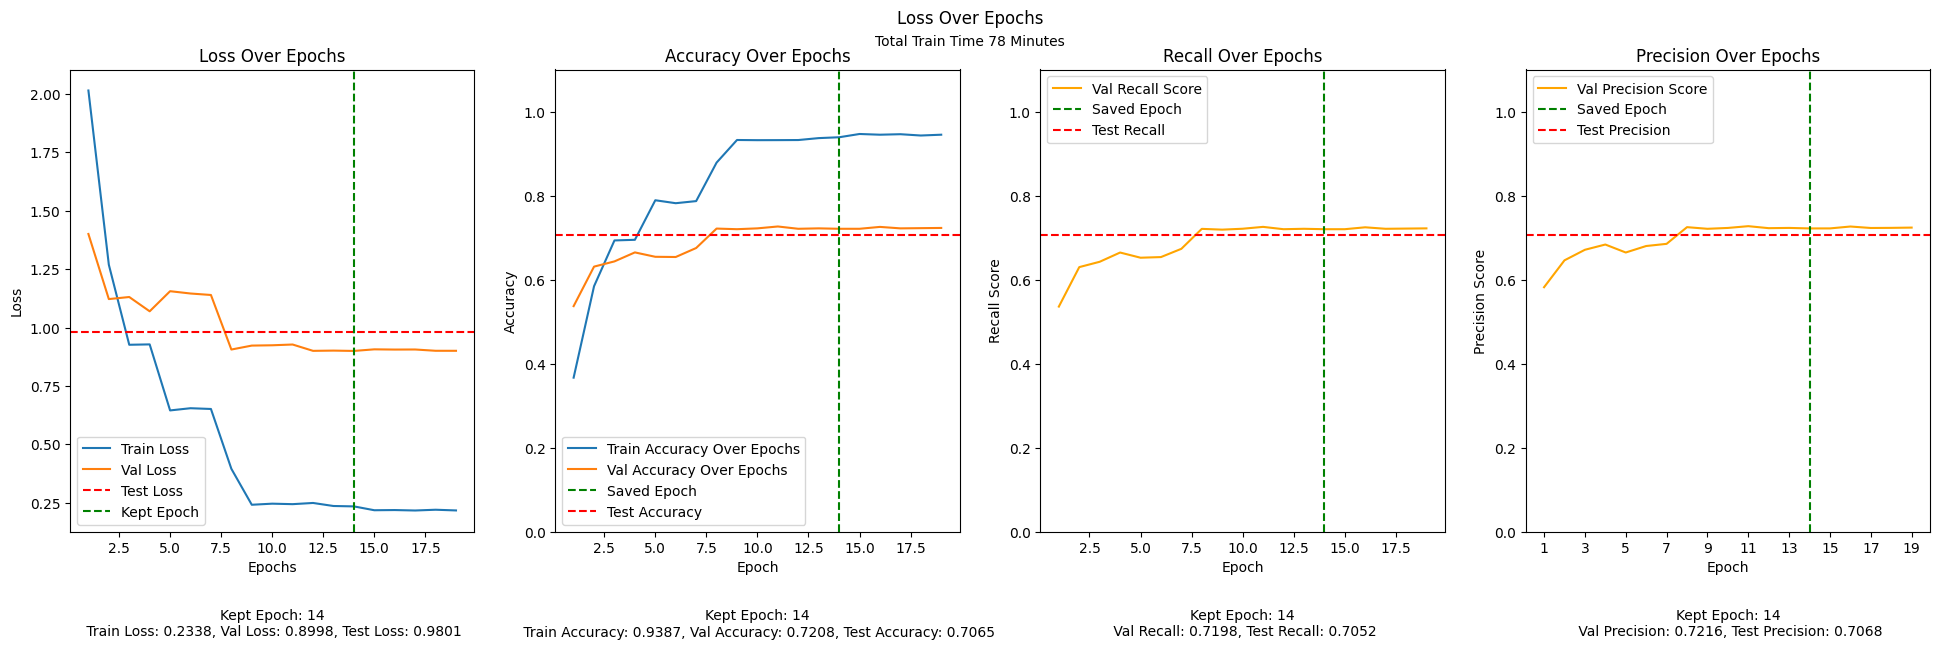

In [14]:
def run_job():
    seed()
    train_loader, val_loader, test_loader = create_loaders(rank, batch_size=32)
    #model hyperparas 
    #embedding dim 
    embedding_dim = 768
    #num heads 
    num_heads = 12
    #encoder blocks 
    num_encoder_blocks = 12
    #num classes for mlp head 
    num_classes = 10
    #dropout 
    dropout = .1

    #training hyperparas 
    #num epochs to train
    num_epochs = 1000
    #patience
    patience = 5
    #max lr 
    lr = 1e-4
    #saving the model, config, logging, and figure
    saving_path = rf'/kaggle/working/rotary_rms_glu_model'

    model = Rotary_RMS_GLU_ViT(embedding_dim, num_heads, num_encoder_blocks, num_classes, dropout).to(rank)
   
    #loss function
    loss_func = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #lr scheduler 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    #init early stopper 
    early_stopper = EarlyStoppingLoss(patience)

    total_params = sum(para.numel() for para in model.parameters())
    print("Number of parameters: ", total_params)
    print()
    # print("The number of parameters each part of the transfromer model")
    # for name, param in model.named_parameters():
    #     print(f"Layer: {name}, Parameters: {param.numel()}")

    config = {'embedding_dim': embedding_dim, 'num_heads': num_heads, 'num_encoder_blocks': num_encoder_blocks, 'num_classes': num_classes, 'num_epochs': num_epochs, 'dropout': dropout, 
              'patience': patience, 'lr': lr, 'total_parameters': total_params}
    
    #model training and testing
    model, history, final_stats_dict, logging_str = train(model, train_loader, val_loader, 
                                                          loss_func, optimizer, early_stopper, 
                                                          scheduler, num_epochs)
    #run test partition 
    test_dict = test(model, test_loader, loss_func)

    #plot figure
    fig = plot(history, final_stats_dict, test_dict)
    fig.suptitle(f'Loss Over Epochs')

    save_model(saving_path, fig, config, model, logging_str)
    
run_job()